In [10]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython.display import display

import segmentation_models as sm

In [3]:
class CFG:
    debug=True

    dataset_dir="../input/ranzcr-clip-catheter-line-classification/"
    batch_size=1 if debug else 64 
    input_size=(576,576)

In [5]:
train=pd.read_csv(f"{CFG.dataset_dir}train.csv")

In [28]:
AUTO=tf.data.experimental.AUTOTUNE

def preprocess(uid):
    path=f"{CFG.dataset_dir}train/"+uid+".jpg"
    file_bytes=tf.io.read_file(path)
    img=tf.io.decode_jpeg(file_bytes)
    img=tf.image.resize(img,CFG.input_size)
    img/=255.0

    return uid,img

def build_dataset(uids,shuffle=256):
    dset=tf.data.Dataset.from_tensor_slices(uids)
    dset=dset.map(preprocess,num_parallel_calls=AUTO)
    dset=dset.cache()
    dset=dset.shuffle(shuffle) if shuffle else dset
    dset=dset.batch(CFG.batch_size,drop_remainder=True).prefetch(AUTO)
    return dset

def decode_str_tensors(tensors):
    return [tensor.numpy().decode() for tensor in tensors]

dset=build_dataset(train["StudyInstanceUID"])

In [23]:
def create_model():
    custom_objects={
        "iou_score":sm.metrics.IOUScore,
        "binary_crossentropy_plus_jaccard_loss":sm.losses.bce_jaccard_loss
    }
    model=tf.keras.models.load_model("./models/pspnet_ckpt", custom_objects=custom_objects)
    # model=sm.PSPNet(classes=1,activation="sigmoid",encoder_weights=None,input_shape=CFG.input_size+(1,))
    # model.compile(optimizer="adam",loss=sm.losses.bce_jaccard_loss,metrics=[sm.metrics.iou_score])
    return model

pspnet=create_model()

In [22]:
def image_show(img,title):
    fig,ax=plt.subplots(1,1,figsize=(5,5))
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(title)
    save_dir="../input/cvc_pspnet_pred/"
    os.makedirs(save_dir,exist_ok=True)
    #fig.savefig(save_dir+title+".jpg")

array([[[8.70619e-33, 0.00000e+00, 0.00000e+00],
        [8.70619e-33, 0.00000e+00, 0.00000e+00],
        [8.70619e-33, 0.00000e+00, 0.00000e+00],
        ...,
        [0.00000e+00, 0.00000e+00, 0.00000e+00],
        [0.00000e+00, 0.00000e+00, 0.00000e+00],
        [0.00000e+00, 0.00000e+00, 0.00000e+00]],

       [[8.70619e-33, 0.00000e+00, 0.00000e+00],
        [8.70619e-33, 0.00000e+00, 0.00000e+00],
        [8.70619e-33, 0.00000e+00, 0.00000e+00],
        ...,
        [0.00000e+00, 0.00000e+00, 0.00000e+00],
        [0.00000e+00, 0.00000e+00, 0.00000e+00],
        [0.00000e+00, 0.00000e+00, 0.00000e+00]],

       [[8.70619e-33, 0.00000e+00, 0.00000e+00],
        [8.70619e-33, 0.00000e+00, 0.00000e+00],
        [8.70619e-33, 0.00000e+00, 0.00000e+00],
        ...,
        [0.00000e+00, 0.00000e+00, 0.00000e+00],
        [0.00000e+00, 0.00000e+00, 0.00000e+00],
        [0.00000e+00, 0.00000e+00, 0.00000e+00]],

       ...,

       [[0.00000e+00, 0.00000e+00, 0.00000e+00],
        [0.

<tf.Tensor: shape=(576, 576, 3), dtype=float32, numpy=
array([[[0.18010622, 0.18010622, 0.18010622],
        [0.23690087, 0.23690087, 0.23690087],
        [0.25042287, 0.25042287, 0.25042287],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.2537854 , 0.2537854 , 0.2537854 ],
        [0.33472225, 0.33472225, 0.33472225],
        [0.34248367, 0.34248367, 0.34248367],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.2600899 , 0.2600899 , 0.2600899 ],
        [0.3397581 , 0.3397581 , 0.3397581 ],
        [0.35617813, 0.35617813, 0.35617813],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.42347473, 0.42347473, 0.42347473],
        [0.55

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


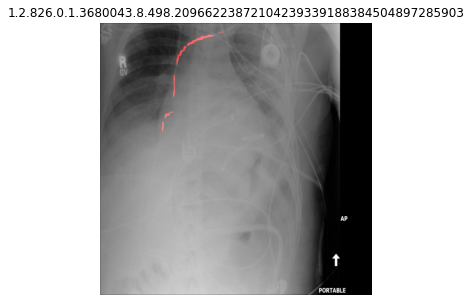

In [30]:
for uids,imgs in dset.take(1):
    uids_decoded=decode_str_tensors(uids)
    preds=pspnet.predict(imgs)
    for uid,pred in zip(uids_decoded,preds):
        pred=pred.reshape(pred.shape[0],pred.shape[1])
        stacked_img=np.stack((pred,)*3,axis=-1)
        stacked_img[:,:,(1,2)]=0

        train_file_bytes=tf.io.read_file(f"../input/ranzcr-clip-catheter-line-classification/train/{uid}.jpg")
        train_img=tf.io.decode_jpeg(train_file_bytes,channels=3)
        train_img=tf.image.resize(train_img,(576,576))
        train_img/=255.0

        display(stacked_img,train_img)

        merged_img=train_img+stacked_img
        image_show(merged_img,uid)